In [1]:
import pickle
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from yellowbrick.classifier import ConfusionMatrix
from sklearn.model_selection import GridSearchCV, KFold, train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_fscore_support
import numpy as np
import scipy.stats as st

***Open with data***

In [27]:
with open('../DataBases/CD4EncodedBase.pkl', 'rb') as f:
    columns, Cd4AttributesTrainingBalanced, Cd4ClassResultsTrainingBalanced, Cd4AttributesTest, Cd4ClassResultsTest = pickle.load(f)
with open('../Databases/VlEncodedBase.pkl', 'rb') as f:
    columns, VlAttributesTrainingBalanced, VlClassResultsTrainingBalanced, Vl4AttributesTest, VlClassResultsTest = pickle.load(f)


***GridSearch for Decision Tree***

In [28]:
params = {
    'max_depth': [5, 10, 20, 30, None],
    'min_samples_split': [3, 5, 10, 20, 50, 100, 150, 180, 200],
    'min_samples_leaf': [3, 5, 10, 20, 50, 100, 150],
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', None]
}

***Creating Grid***

In [6]:
grid = GridSearchCV(
    DecisionTreeClassifier(),
    param_grid=params,
    cv=5,
    verbose=1,
    n_jobs=-1
)

***Run Grid***

In [29]:

grid.fit(Cd4AttributesTrainingBalanced, Cd4ClassResultsTrainingBalanced)

Fitting 5 folds for each of 1260 candidates, totalling 6300 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, 20, 30, None],
                         'max_features': ['sqrt', None],
                         'min_samples_leaf': [3, 5, 10, 20, 50, 100, 150],
                         'min_samples_split': [3, 5, 10, 20, 50, 100, 150, 180,
                                               200]},
             verbose=1)

In [30]:
print(grid.best_params_)
print(grid.best_score_)
best_model = grid.best_estimator_
best_params = grid.best_params_

{'criterion': 'entropy', 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 200}
0.7438640203758677


***Perform k-fold cross-validation and evaluate best model***

In [36]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from copy import deepcopy

kf = KFold(n_splits=15, shuffle=True, random_state=42)
best_accuracy = 0
best_model_kfold = None

# Create an empty list to store the metrics from each fold
accuracy = []
precision_scores_class_0 = []
precision_scores_class_1 = []
recall_scores_class_0 = []
recall_scores_class_1 = []
f1_scores_class_0 = []
f1_scores_class_1 = []
fold = 0

# Perform k-fold cross-validation
for train_index, val_index in kf.split(VlAttributesTrainingBalanced):
    X_train, X_val = Cd4AttributesTrainingBalanced[train_index], Cd4AttributesTrainingBalanced[val_index]
    y_train, y_val = Cd4ClassResultsTrainingBalanced[train_index], Cd4ClassResultsTrainingBalanced[val_index]

    # Fit the model on the training data
    best_model.fit(X_train, y_train)

    # Predict the labels for the validation data
    y_pred = best_model.predict(X_val)

    # Store the precision, recall, and F-measure scores for each class
    precision, recall, fscore, support = precision_recall_fscore_support(y_val, y_pred, average=None)
    accuracy.append(accuracy_score(y_val, y_pred))
    precision_scores_class_0.append(precision[0])
    precision_scores_class_1.append(precision[1])
    recall_scores_class_0.append(recall[0])
    recall_scores_class_1.append(recall[1])
    f1_scores_class_0.append(fscore[0])
    f1_scores_class_1.append(fscore[1])

    # Update the best model if a better accuracy is found
    fold_accuracy = accuracy_score(y_val, y_pred)
    if fold_accuracy > best_accuracy:
        best_accuracy = fold_accuracy
        best_model_kfold = deepcopy(best_model)

    fold += 1

precision_avg_class_0 = np.round(np.mean(precision_scores_class_0), 3)
precision_avg_class_1 = np.round(np.mean(precision_scores_class_1), 3)
recall_avg_class_0 = np.round(np.mean(recall_scores_class_0), 3)
recall_avg_class_1 = np.round(np.mean(recall_scores_class_1), 3)
f1_avg_class_0 = np.round(np.mean(f1_scores_class_0), 3)
f1_avg_class_1 = np.round(np.mean(f1_scores_class_1), 3)
accuracy_avg = np.round(np.mean(accuracy), 3)

print("Average Precision - Class 0:", precision_avg_class_0)
print("Average Precision - Class 1:", precision_avg_class_1)
print("---------------------------------------------------")
print("Average Recall - Class 0:", recall_avg_class_0)
print("Average Recall - Class 1:", recall_avg_class_1)
print("---------------------------------------------------")
print("Average F1 Score - Class 0:", f1_avg_class_0)
print("Average F1 Score - Class 1:", f1_avg_class_1)
print("---------------------------------------------------")
print("Average Accuracy:", accuracy_avg)
print("Best Model Accuracy:", best_accuracy)


Average Precision - Class 0: 0.657
Average Precision - Class 1: 0.728
---------------------------------------------------
Average Recall - Class 0: 0.6
Average Recall - Class 1: 0.772
---------------------------------------------------
Average F1 Score - Class 0: 0.625
Average F1 Score - Class 1: 0.748
---------------------------------------------------
Average Accuracy: 0.7
Best Model Accuracy: 0.7518796992481203


***Executing Decision Tree***

In [37]:
dtc = best_model
model = dtc.fit(Cd4AttributesTrainingBalanced, Cd4ClassResultsTrainingBalanced)
dtc.score(Cd4AttributesTest, Cd4ClassResultsTest)

0.7092950717404866

***Confidence Interval***

In [38]:
#Function for calculating confidence interval from cross-validation
def interval_confidence(values):
    return st.t.interval(confidence=0.95, df=len(values)-1, loc=np.mean(values), scale=st.sem(values))
    
# Calculate confidence intervals for precision, recall, and F1 scores of each class
precision_ci_class_0 = interval_confidence(np.array(precision_scores_class_0))
precision_ci_class_1 = interval_confidence(np.array(precision_scores_class_1))
recall_ci_class_0 = interval_confidence(np.array(recall_scores_class_0))
recall_ci_class_1 = interval_confidence(np.array(recall_scores_class_1))
fscore_ci_class_0 = interval_confidence(np.array(f1_scores_class_0))
fscore_ci_class_1 = interval_confidence(np.array(f1_scores_class_1))
accuracy_ci = interval_confidence(np.array(accuracy))

# Print confidence intervals for each class
print("95% Confidence Interval - Precision - Class 0:")
print(precision_ci_class_0)
print("---------------------------------------------------")
print("95% Confidence Interval - Precision - Class 1:")
print(precision_ci_class_1)
print("---------------------------------------------------")
print("95% Confidence Interval - Recall - Class 0:")
print(recall_ci_class_0)
print("---------------------------------------------------")
print("95% Confidence Interval - Recall - Class 1:")
print(recall_ci_class_1)
print("---------------------------------------------------")
print("95% Confidence Interval - F1 Score - Class 0:")
print(fscore_ci_class_0)
print("---------------------------------------------------")
print("95% Confidence Interval - F1 Score - Class 1:")
print(fscore_ci_class_1)
print("---------------------------------------------------")
print("95% Confidence Interval - Accuracy:")
print(accuracy_ci)


95% Confidence Interval - Precision - Class 0:
(0.620728066734512, 0.6941105044426094)
---------------------------------------------------
95% Confidence Interval - Precision - Class 1:
(0.7088209046666613, 0.7464928219424468)
---------------------------------------------------
95% Confidence Interval - Recall - Class 0:
(0.5704647786455982, 0.6296873745704211)
---------------------------------------------------
95% Confidence Interval - Recall - Class 1:
(0.7441849780336288, 0.8001709572001018)
---------------------------------------------------
95% Confidence Interval - F1 Score - Class 0:
(0.5997214986342368, 0.6505252318303408)
---------------------------------------------------
95% Confidence Interval - F1 Score - Class 1:
(0.7315072542801929, 0.7647694165868423)
---------------------------------------------------
95% Confidence Interval - Accuracy:
(0.6841623754551915, 0.7160400173191972)


***Analisando métricas do melhor k-fold***

***Analisando métricas da Decision Tree criada***

              precision    recall  f1-score   support

           0       0.64      0.67      0.66       667
           1       0.76      0.73      0.75       936

    accuracy                           0.71      1603
   macro avg       0.70      0.70      0.70      1603
weighted avg       0.71      0.71      0.71      1603



c:\Users\gusta\AppData\Local\Programs\Python\Python310\lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


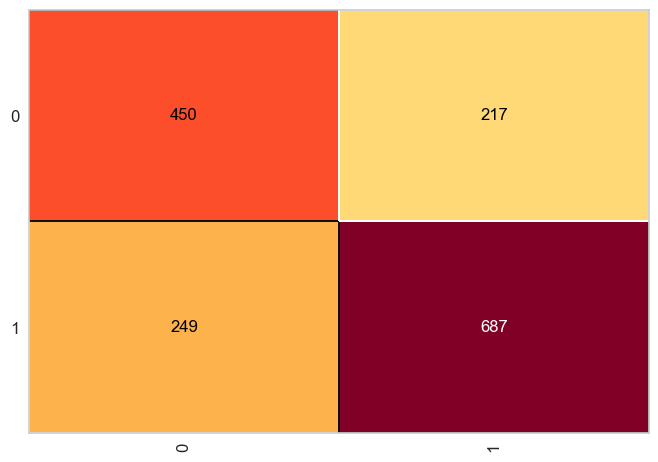

In [40]:
from sklearn.metrics import confusion_matrix

cm = ConfusionMatrix(model)
cm.score(Cd4AttributesTest, Cd4ClassResultsTest)
y_pred = model.predict(Cd4AttributesTest)
report = classification_report(Cd4ClassResultsTest, y_pred)
print(report)